# Statistical Analysis of Adoptable Animals Data


* The EDA brought about a few interesting questions that we can hypothesize about.


* While testing the validity and statistical significance of the hypotheses, we may come up with more interesting questions.


* The quetions/hypotheses drawn from the EDA done in the previous notebook are:
    * Notes: Adoptability will be calculated as the ratio of Adoptions:All other shelter outcomes.
    * Notes: I will employ hacker statistics for all testing as they are widely applicable and I have enough computing power to produce viable results.
    
    
    1. Does age play an important role in the adoptability/time to adoption of the dogs?
        * The ages of interest are puppies/non puppies.
        * I will test the hypothesis that puppies get adopted more often and quicker than older dogs.
        
     
    2. Does having a secondary color make dogs more adoptable and decreases the time to adoption?
        * I will test the hypothesis that dogs that have secondary colors are more adoptable and will get adopted sooner than dogs without secondary colors.
        
        
    3. Is there a difference in adoptability/time to adoption for males as compared to females?
        * I hypothesize that there isn't a difference.
        
        
    4. Does the populous of a breed in the shelter play an important role in adoptability?
        * So sample size isn't too uneven, I will test the top 5 breeds that enter the shelter versus all the others.
        
        
    5. Does the primary breed American Kennel Club group play an influential role in adoptability/time to adoption?
        * There are 8 AKC breed groupings.
        * Does any one grouping stand out from the rest in terms of adoptability/time to adoption?
        * I hypothesize that one will and breed is an important factor.
        
        
    6. Is there a correlation between time to adoption and intake age?
        * I hypothesize that there is a correlation.
        
        
    7. Are adoptions affected by seasons?
        * I hypothesize that occur more often in the spring and fall than in summer or winter.
        
*****

### First step is to load the data needed.

In [1]:
#load the necessary datasets and packages
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy import stats

dogs_join = pd.read_csv("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_join.csv", 
                        parse_dates=True, encoding='latin-1')
dogs_adoptions = pd.read_csv("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_adoptions.csv", 
                        parse_dates=True, encoding='latin-1')
dogs_transfers = pd.read_csv("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_transfers.csv", 
                        parse_dates=True, encoding='latin-1')
dogs_deaths = pd.read_csv("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_deaths.csv", 
                        parse_dates=True, encoding='latin-1')
return_visits = pd.read_csv("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/return_visits.csv", 
                        parse_dates=True, encoding='latin-1')
with open("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dog_ages.json") as file:
    dog_ages = json.load(file) 
with open("C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/seasons.json") as file:
    seasons = json.load(file)
    
#create a column in the dogs_join dataframe that changes the outcome_type to the three categories 
#above (adoptions, transfers, deaths)
for index, row in dogs_join.iterrows():
    if row['outcome_type'] in dogs_adoptions.outcome_type.unique():
        dogs_join.loc[index, 'outcome_type'] = 'Adoption'
    elif row['outcome_type'] in dogs_transfers.outcome_type.unique():
        dogs_join.loc[index, 'outcome_type'] = 'Transfer'
    else:
        dogs_join.loc[index, 'outcome_type'] = 'Death'

C:\Users\sethh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
#check to see if the loop worked.
dogs_join.outcome_type.unique()

array(['Adoption', 'Transfer', 'Death'], dtype=object)

#### Set up the test statistics and functions to calculate them.
* For adoptability, I will calculate the difference in the fraction of category of interest adopted and the non category adopted from the sample population.
* Time to adoption will be assessed via difference of expected values of an exponential distribution (standard deviation) of time to adoption of category vs. non category.
    *  This is because time to adoption is roughly exponentially distributed as shown earlier and this is more accurate as to the time to adoption summary stat for groups in the shelter.

In [3]:
#we need to break the data up into category and non category for each category
#define a function to generate the groupings dataframes
def group_dfs(df, col, category):
    """
    Groups the dataframes into the correct groupings based off of a identifier from a dataframe column
    """
    cat = df.loc[df[col] ==category]
    non_cat = df.loc[df[col] !=category]
    return(cat, non_cat)
    
#also now define the function to calculate the difference in adoption percentages
def diff_adopt_per(data1, data2, data1_adopt, data2_adopt):
    """
    Takes dataframes or series or arrays 1 and 2 and the adoptions from those dataframes or series
    or arrays and returns the difference in adoption percentages from the
    two dataframes/categories.
    """
    adopt1 = len(data1_adopt)/len(data1)
    adopt2 = len(data2_adopt)/len(data2)
    diff_adopt = adopt2 - adopt1
    return(diff_adopt, adopt1, adopt2)

#and define a function to calculate the difference of 3rd quantiles
def diff_std_dev(data1, data2):
    return(np.std(data2) - np.std(data1))

* Now we need to make a function to run the statistical test for difference in time to adoptions and adoptability.
    * For both tests, the null hypothesis is that there is not a difference, and the test will be set up under this assumption.
        * The assumption being that the the distribution of adoptions between the two groups are not different.
    * Use permutation replicates to generate samples to create a distribution of differences for both adoptability and 3rd quantiles of time to adoptions.
    * The p-value of the test will be calculated by taking the number of permutation replicates that have a difference as extreme or more extreme than the empirical difference divided by the total number of permutation replicates generated.


* The test setup for difference in adoptability:
    * The test statistic is going to be the difference of the adoption ratios between the two groups.
    * The first step calculate the empirical ratio values and differences between those values.
    * Then, model the data to represent the null hypothesis, which is that there isn't a difference in adoption distributions between the two groups.
        * Done by concatenating the two groups and taking a permutation of the data as a whole.
        * Then, assign the permuted results out to each group according to the number of entries contributed to the concatenated array by that group.
            * For instance, puppy vs. non-puppy, the first ~23,000 would be put into the permuted puppy array, and the rest int the permuted non-puppy array.
    * Next, calculate the test statistic which is the permuted ratios and difference of those ratios.  
    * Repeat this many times to generate a distribution of differences in permuted ratios.
    * The p-value is finally calculated by taking the number of permuation replicates (difference in permuted ratios) that are as least as extreme as the empirical difference in ratios.
    
    
* The test setup for difference in time to adoption:
    * The test statistic is going to be the difference in 3rd quartiles of the time to adoption for the different categories.
    * Calculate the empirical difference of 3rd quartiles of time to adoption values.
    * Then, model the data to represent the null hypothesis, which is that there isn't a difference in time to adoption distributions between the two groups.
        * Done by concatenating the two groups and taking a permutation of the data as a whole.
        * Then, assign the permuted results out to each group according to the number of entries contributed to the concatenated array by that group.
    * Next, calculate the test statistic, which is the difference of 3rd quartiles of the permuted samples.
    * Repeat this many times to generate a distribution of differences in 3rd quartiles.
    * The p-value is finally calculated by taking the number of permuation replicates (difference in permuted 3rd quartiles) that are as least as extreme as the empirical difference in 3rd quartiles.

In [4]:
#define the functions to run the statistical test for difference in adoptability
def perm_rep_draw(calc,data1,data2,func,size):
    """Generates permutation replicates of desired size and function."""
    
    # Initialize permutation replicates: perm_replicates
    perm_replicates = np.empty(size)
    
    #set lengths of categories
    cat_length = len(data1)
    
    #concatenate the two data groups
    concat_data = data1.append(data2).reset_index(drop=True)
    concat_index = concat_data.index.values
    
    # Draw perm_replicates
    for i in range(size):
        # Permute index and split into sets
        permuted_index = np.random.permutation(concat_index)
        permuted_cat_index = permuted_index[:cat_length]
        permuted_non_cat_index = permuted_index[cat_length:]
        
        # Now assign the permuted data based on the permuted index
        permuted_cat = concat_data[permuted_cat_index]
        permuted_non_cat = concat_data[permuted_non_cat_index]

        # Compute replicate with function from data low and high
        if calc == 'ratio':
            perm_replicates[i],j,k  = func(permuted_cat, permuted_non_cat, permuted_cat[permuted_cat=='Adoption'],permuted_non_cat[permuted_non_cat=='Adoption'])
        else:
            perm_replicates[i] = func(permuted_cat, permuted_non_cat)
    return perm_replicates

def adopt_diff_test(col, category, num_reps):
    """
    Executes the adoption ratio statistical test on the column and category(grouping) of choice by generating num_reps number
    of replicates.
    """
    #set up test parameters
    cat, non_cat = group_dfs(dogs_join, col, category)
    cat_adopt, non_cat_adopt = group_dfs(dogs_join.loc[dogs_join.outcome_type=='Adoption'], col, category)
    
    
    print((category + " group data points: {}. Non-" + category + " group data points: {}.")
          .format(len(cat), len(non_cat)))

    #empirical difference of ratios
    emp_diff_ratio, emp_cat, emp_non = diff_adopt_per(cat, non_cat, cat_adopt, non_cat_adopt)
    print('The empirical '+category+(' ratio:{}').format(emp_cat))
    print(('The empirical non-'+category+' ratio:{}').format(emp_non))
    print('The empirical difference of ratios(non minus cat) is {}.'.format(emp_diff_ratio))
    print('')
        
    #generate the replicates
    perm_replicates = perm_rep_draw('ratio', cat['outcome_type'], non_cat['outcome_type'], diff_adopt_per, num_reps)
        
    # Compute p-value: p
    if emp_diff_ratio > 0:
        p = np.sum(perm_replicates >= emp_diff_ratio)/len(perm_replicates)
    else:
        p = np.sum(perm_replicates <= emp_diff_ratio)/len(perm_replicates)
    print("The 95% confidence interval is {} to {}.".format(np.percentile(perm_replicates,2.5),np.percentile(perm_replicates,97.5)))
    print('p-val =', p)

    #make a histogram of the replicate correlations and show where the empirical result lies
    plt.figure(figsize=(12,6))
    pd.Series(perm_replicates).hist(alpha=0.3, normed=True, bins=50)
    plt.plot([emp_diff_ratio,emp_diff_ratio], [0,80])
    plt.title('Difference in Means of Ratios between ' + category + ' and non-' + category)
    plt.ylabel('PDF')
    plt.xlabel('Difference of Ratios non-'+category+' minus '+category)
    plt.legend(['Empirical Difference','Difference Replicates'], loc='upper left')
    plt.show()
    
    
def time_diff_test(col, category, num_reps):
    #set up test parameters
    cat_adopt, non_cat_adopt = group_dfs(dogs_join.loc[dogs_join.outcome_type=='Adoption'], col, category)
    
    
    print((category + " group data points: {}. Non-" + category + " group data points: {}.")
          .format(len(cat_adopt), len(non_cat_adopt)))

    #empirical difference of standard deviations
    emp_diff_std = diff_std_dev(cat_adopt.shelter_time, non_cat_adopt.shelter_time)
    print((category + ' std:{}').format(np.std(cat_adopt.shelter_time)))
    print(('Non-'+category+' std:{}').format(np.std(non_cat_adopt.shelter_time)))
    print('The empirical difference of time to adoption expected value or standard deviation(non minus cat) is {}.'.format(emp_diff_std))
    print('')
        
    #generate the replicates
    perm_replicates = perm_rep_draw('std', cat_adopt['shelter_time'], non_cat_adopt['shelter_time'], diff_std_dev, num_reps)
        
    # Compute p-value: p
    if emp_diff_std > 0:
        p = np.sum(perm_replicates >= emp_diff_std)/len(perm_replicates)
    else:
        p = np.sum(perm_replicates <= emp_diff_std)/len(perm_replicates)
    print("The 95% confidence interval is {} to {}.".format(np.percentile(perm_replicates,2.5),np.percentile(perm_replicates,97.5)))
    print('p-val =', p)

    #make a histogram of the replicate correlations and show where the empirical result lies
    plt.figure(figsize=(12,6))
    pd.Series(perm_replicates).hist(alpha=0.3, normed=True, bins=50)
    plt.plot([emp_diff_std,emp_diff_std], [0,.3])
    plt.title('Difference in Standard Deviation between ' + category + ' and non-' + category)
    plt.ylabel('PDF')
    plt.xlabel('Difference of standard deviation non-'+category+' minus '+category)
    plt.legend(['Empirical Difference','Difference Replicates'], loc='upper left')
    plt.show()

## 1. Does age play an important role in the adoptability/time to adoption of the dogs?
* I hypothesize that there is a difference between puppies' and non-puppies' adoptability and time to adoptions.
* Puppies are defined as being less than or equal to 1 year old, and all other ages or defined as non-puppies.
* Test significance level is $\alpha$ = 0.05.
* Null hypothesis is that there isn't a difference in distributions of adoptions or time to adoption

Puppy group data points: 23829. Non-Puppy group data points: 25164.
The empirical Puppy ratio:0.7310420076377523
The empirical non-Puppy ratio:0.7535765379113019
The empirical difference of ratios(non minus cat) is 0.02253453027354957.

The 95% confidence interval is -0.0076146081603960525 to 0.008072748423120335.
p-val = 0.0


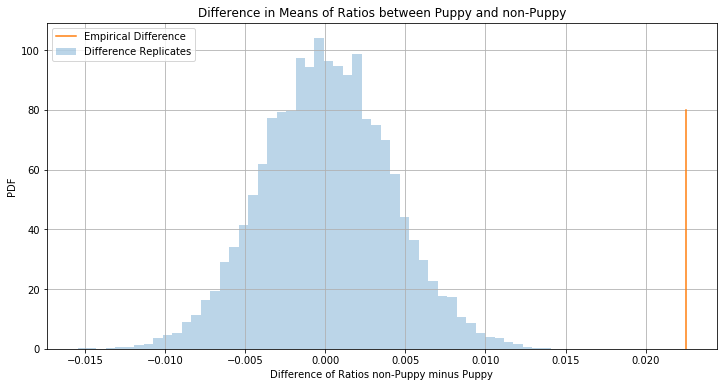

Puppy group data points: 17420. Non-Puppy group data points: 18963.
Puppy std:29.35479116066151
Non-Puppy std:57.05842804294061
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 27.703636882279103.

The 95% confidence interval is -6.39527829184939 to 6.152377076564272.
p-val = 0.0


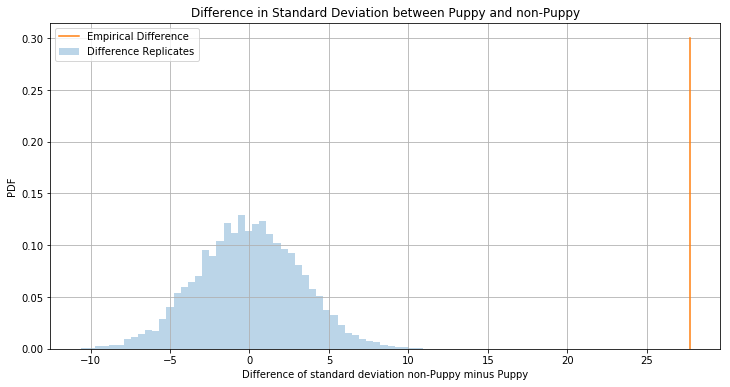

In [5]:
#set the random seed and run the test
np.random.seed(42)

#adoption ratio test
adopt_diff_test('intake_age_cat', 'Puppy', 10000)

#time to adoption test
time_diff_test('intake_age_cat', 'Puppy', 10000)

### Results (Puppy vs. Non-Puppy)
* The test shows that in 10000 iterations, there was not one case found where the difference in adoption ratios was as extreme as the empirical difference in adoption ratios.
* So we can reject the null hypothesis that there is not a difference in adoption ratios between puppies and non puppies.  The p-value is below $\alpha$. 
* Moreover, the empirical difference in ratios suggests that Non-Puppies (anything not classified in the age range of a puppy) are adopted more than puppies.


* For the time to adoption tests it seems that the null hypothesis can be rejected as well and that there is a statistical result that the distributions of time to adoptions aren't the same.
    * It seems that the time adoption may indeed take longer for non-puppies based on the result above. 
    
*****

## 2. Does Solid vs. Mixed Coat coloration have an effect on adoptions and time to adoption?
* I hypothesize that there is a difference between solid and mixed coat color adoptions and time to adoption.
* Solids are defined as having a secondary color value of 'None', and all other dogs have mixed coat color.
* Test significance level is $\alpha$ = 0.05.
* Null hypothesis is that there isn't a difference in distributions of adoptions or time to adoption

None group data points: 16916. Non-None group data points: 32077.
The empirical None ratio:0.7261172854102624
The empirical non-None ratio:0.751317143124357
The empirical difference of ratios(non minus cat) is 0.02519985771409461.

The 95% confidence interval is -0.008027088740041433 to 0.008044640794839575.
p-val = 0.0


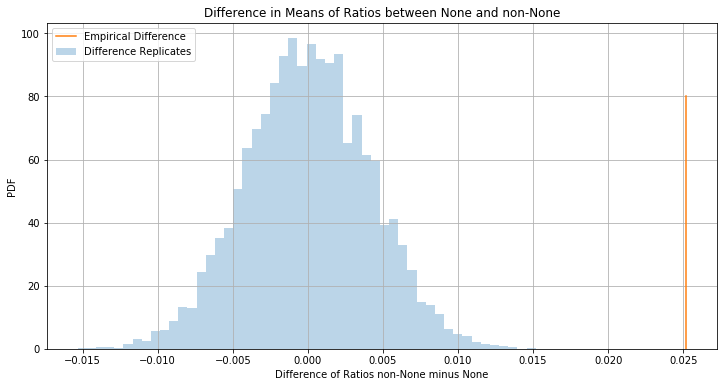

None group data points: 12283. Non-None group data points: 24100.
None std:44.14967286584886
Non-None std:46.8950781110967
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 2.745405245247838.

The 95% confidence interval is -6.683292468429277 to 6.42059217653701.
p-val = 0.2219


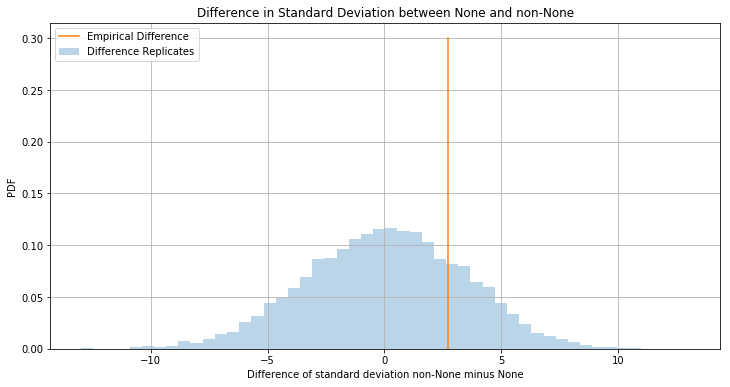

In [6]:
#adoption ratio test
adopt_diff_test('color2', 'None', 10000)

#time to adoption test
time_diff_test('color2', 'None', 10000)

### Results (Solid vs. Mixed)
* The test shows that in 10000 iterations, there was not one case found where the difference in adoption ratios was as extreme as the empirical difference in adoption ratios.
* So we can reject the null hypothesis that there is not a difference in adoption ratios between solid and mixed coat color.  The p-value is below $\alpha$. 
* Moreover, the empirical difference in ratios suggests that Mixed Color dogs are adopted more than solid color dogs.


* For the time to adoption tests it seems that the null hypothesis cannot be rejected.  The test did not yield a significant result with p-value beind > $\alpha$.
    * It seems that the time adoption distributions and expected values are very similar for solid and mixed color dogs. 
    
*****

## 3. Does the gender of the dog have a significant impact on adoptions and time to adoption?
* I hypothesize that there isn't a difference between male and female adoptions and time to adoption.
* Since there are only 282 unknown values for gender, I will lump these in together with Females as the count of females is lower than males.
* Test significance level is  αα  = 0.05.
* Null hypothesis is that there isn't a difference in distributions of adoptions or time to adoption

In [7]:
#checking counts of each group
dogs_join.intake_sex.value_counts()

Male       26201
Female     22510
Unknown      282
Name: intake_sex, dtype: int64

Male group data points: 26201. Non-Male group data points: 22792.
The empirical Male ratio:0.7488263806724934
The empirical non-Male ratio:0.7354773604773605
The empirical difference of ratios(non minus cat) is -0.013349020195132955.

The 95% confidence interval is -0.007934279474487882 to 0.00773565200495463.
p-val = 0.0005


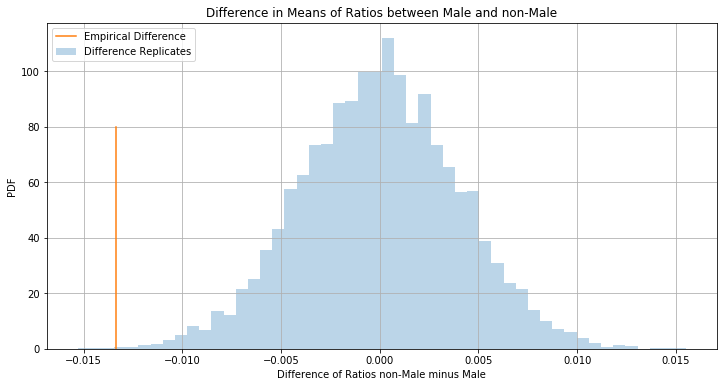

Male group data points: 19620. Non-Male group data points: 16763.
Male std:44.16453722185599
Non-Male std:48.07091809083546
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 3.9063808689794755.

The 95% confidence interval is -6.190034977435704 to 6.220208428042056.
p-val = 0.1117


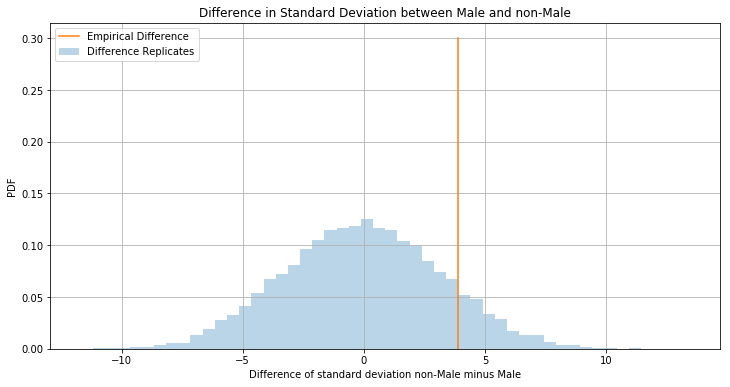

In [8]:
#adoption ratio test
adopt_diff_test('intake_sex', 'Male', 10000)

#time to adoption test
time_diff_test('intake_sex', 'Male', 10000)

### Results (Male vs. Female)
* The test shows that in 10000 iterations, there was only a few instances found where the difference in adoption ratios was as extreme as the empirical difference in adoption ratios.
* So we can reject the null hypothesis that there is not a difference in adoption ratios between male and female.  The p-value is below $\alpha$. 
* Moreover, the empirical difference in ratios suggests that Male dogs are adopted more than Female dogs.


* For the time to adoption tests it seems that the null hypothesis cannot be rejected.  The test did not yield a significant result with p-value being > $\alpha$.
    * It seems that the time adoption distributions and expected values are similar for Male and Female dogs. 
    
*****

## 4. Does breed population impact adoptions and time to adoptions?
* I hypothesize that there is a difference between populous breeds and non-populous breeds adoptions and time to adoption.
* To test this, the groups will be the top 5 primary breeds in intakes vs. the rest of the breeds.
* Test significance level is  $\alpha$  = 0.05.
* Null hypothesis is that there isn't a difference in distributions of adoptions or time to adoption.

In [9]:
#need to make a column for top vs. none top 5
for index, row in dogs_join.iterrows():
    if row['breed1'] in dogs_join.breed1.value_counts()[:5].index.values:
        dogs_join.loc[index, 'population'] = 'top5'
    else:
        dogs_join.loc[index, 'population'] = 'bottom'

top5 group data points: 24765. Non-top5 group data points: 24228.
The empirical top5 ratio:0.7389057137088633
The empirical non-top5 ratio:0.7464091134224864
The empirical difference of ratios(non minus cat) is 0.007503399713623127.

The 95% confidence interval is -0.007602613652033852 to 0.007748362092525607.
p-val = 0.0292


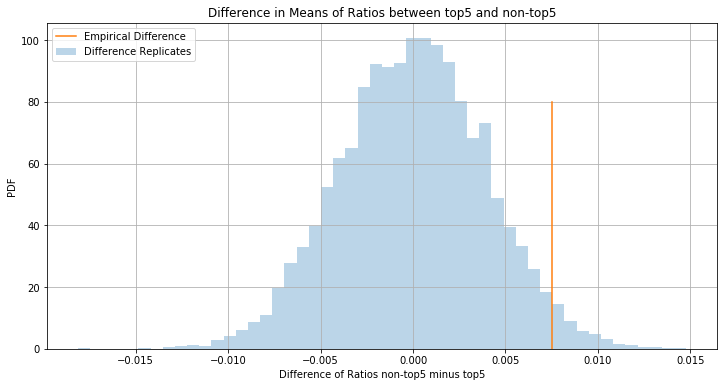

top5 group data points: 18299. Non-top5 group data points: 18084.
top5 std:50.945896914549834
Non-top5 std:40.2127396514153
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is -10.733157263134537.

The 95% confidence interval is -6.3664382411297735 to 6.134597209854777.
p-val = 0.0003


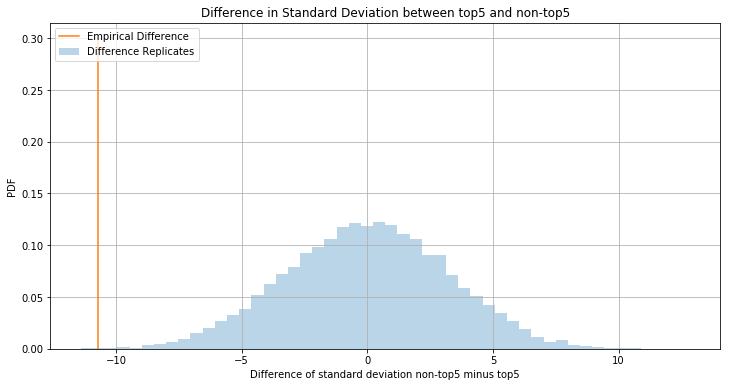

In [10]:
#adoption ratio test
adopt_diff_test('population', 'top5', 10000)

#time to adoption test
time_diff_test('population', 'top5', 10000)

### Results (Populous Breeds  vs. Non-populous Breeds)
* The test shows that in 10000 iterations, there was only a few instances found where the difference in adoption ratios was as extreme as the empirical difference in adoption ratios.
* So we can reject the null hypothesis that there is not a difference in adoption ratios between populous and non-populous.  The p-value is below $\alpha$. 
* Moreover, the empirical difference in ratios suggests that Non-populous breeds are adopted at a higher ratio than populous breeds.


* For the time to adoption tests it seems that the null hypothesis can be rejected.  The test yielded a significant result with p-value being < $\alpha$.
    * It seems that the time adoption distributions and expected values are different for Populous and Non-populous breeds.
    * Moreover, the expected value for time to adoption seems to be higher for the populous breeds.
    
*****

## 5. Does any American Kennel Club Breed Group have better adoptability or time to adoption?
* I hypothesize that certain breed groups have a difference in distribution of adoptions and times to adoption.
* To test this, the groups will be the breeds are separated into the AKC groups and tested one vs. all for each AKC group.
* Test significance level is  $\alpha$  = 0.05.
* Null hypothesis is that there isn't a difference in distributions of adoptions or time to adoption.

In [14]:
#try to group breeds into AKC groups
AKC_breeds = {'Hound':['Afghan Hound','American English Coonhound','American Foxhound','Basenji','Basset Hound','Beagle',
                       'Black and Tan Coonhound','Bloodhound','Bluetick Coonhound','Borzoi','Cirneco Dell’Etna','Dachshund',
                       'English Foxhound','Grand Basset Griffon Vendeen','Greyhound','Harrier','Ibizan Hound','Irish Wolfhound',
                       'Norwegian Elkhound','Otterhound','Petit Basset Griffon Vendeen','Pharaoh Hound','Plott',
                       'Portuguese Podengo Pequeno','Redbone Coonhound','Rhodesian Ridgeback','Saluki','Scottish Deerhound',
                       'Sloughi','Treeing Walker Coonhound','Whippet','Rhod Ridgeback','Plott Hound','Dachshund Stan',
                       'Podengo Pequeno','Dachshund Longhair','Pbgv','English Coonhound','Bluetick Hound','Redbone Hound',
                      'Dachshund Wirehair'],
             'Herding':['Australian Cattle Dog','Australian Shepherd','Bearded Collie','Beauceron','Belgian Malinois',
                        'Belgian Sheepdog','Belgian Tervuren','Bergamasco','Berger Picard','Border Collie','Bouvier des Flandres',
                        'Briard','Canaan Dog','Cardigan Welsh Corgi','Collie','Entlebucher Moutain Dog','Finnish Lapphund',
                        'German Shepherd Dog','German Shepherd','Icelandic Sheepdog','Miniature American Shepherd','Norwegian Buhund',
                        'Old English Sheepdog','Pembroke Welsh Corgi','Polish Lowland Sheepdog','Puli','Pumi','Pyrenean Shepherd',
                        'Queensland Heeler','Shetland Sheepdog','Spanish Water Dog','Swedish Vallhund','Blue Lacy','Entlebucher',
                       'Picardy Sheepdog','Bouv Flandres','Collie Rough','Collie Smooth'],
             'Toy':['Affenpinscher','Brussels Griffon','Cavalier King Charles Spaniel','Chihuahua','Chihuahua Shorthair','Chinese Crested',
                    'English Toy Spaniel','Havanese','Italian Greyhound','Japanese Chin','Maltese','Manchester Terrier',
                    'Miniature Pinscher','Papillon','Pekingese','Pomeranian','Toy Poodle','Pug','Shih Tzu','Silky Terrier',
                    'Toy Fox Terrier','Yorkshire Terrier','Chihuahua Longhair','Bruss Griffon','Cavalier Span','Eng Toy Spaniel'],
             'Non-Sporting':['American Eskimo','American Eskimo Dog','Bichon Frise','Boston Terrier','Bulldog','Chinese Shar-Pei','Chow Chow',
                             'Coton De Tulear','Dalmatian','Finish Spitz','French Bulldog','Keeshond','Lhasa Apso','Lowchen',
                             'Norwegian Lundhund','Poodle','Schipperke','Shiba Inu','Tibetan Spaniel','Tibetan Terrier',
                             'Xoloitzcuintli','Chinese Sharpei','Miniature Poodle','American Bulldog','Finnish Spitz',
                            'English Bulldog', 'Old English Bulldog','Standard Poodle','Mexican Hairless'],
             'Sporting':['American Water Spaniel','Boykin Spaniel','Brittany','Chesapeake Bay Retriever','Clumber Spaniel',
                         'Cocker Spaniel','Curly-Coated Retriever','English Cocker Spaniel','English Setter',
                         'English Springer Spaniel','Field Spaniel','Flat-Coated Retriever','German Shorthaired Pointer',
                         'German Wirehaired Pointer','Golden Retriever','Gordon Setter','Irish Red and White Setter',
                         'Irish Setter','Irish Water Spaniel','Labrador Retriever','Lagotto Romagnolo',
                         'Nederlandse Kooikerhondje','Nova Scotia Duck Tolling Retriever','Pointer','Spinone Italiano',
                         'Sussex Spaniel','Vizsla','Weimaraner','Welsh Springer Spaniel','Wirehaired Pointing Griffon',
                         'Wirehaired Vizsla','German Shorthair Pointer','Flat Coat Retriever','Chesa Bay Retr','English Pointer',
                        'Boykin Span','Sussex Span'],
              'Terrier':['Airedale Terrier','American Hairless Terrier','American Staffordshire Terrier','Australian Terrier',
                         'Bedlington Terrier','Border Terrier','Bull Terrier','Cairn Terrier','Cesky Terrier',
                         'Dandie Dinmont Terrier','Glen of Imaal Terrier','Irish Terrier','Jack Russell Terrier',
                         'Kerry Blue Terrier','Lakeland Terrier','Manchester Terrier','Miniature Bull Terrier','Miniature Schnauzer',
                         'Norfolk Terrier','Norwich Terrier',
                         'Parson Russell Terrier','Pit Bull','Rat Terrier','Russell Terrier','Scottish Terrier','Sealyham Terrier',
                         'Skye Terrier','Smooth Fox Terrier','Soft Coated Wheaten Terrier','Staffordshire Bull Terrier',
                         'Staffordshire','Welsh Terrier','West Highland White Terrier','Wire Fox Terrier','West Highland',
                        'Wire Hair Fox Terrier','Bull Terrier Miniature','Dandie Dinmont','Bedlington Terr','Glen Of Imaal',
                        'Sealyham Terr'],
             'Working':['Akita','Alaskan Malamute','Anatolian Shepherd Dog','Bernese Mountain Dog','Black Russian Terrier',
                        'Boerboel','Boxer','Bullmastiff','Cane Corso','Catahoula','Chinook','Doberman Pinscher','Dogue de Bordeaux',
                        'German Pinscher','Giant Schnauzer','Great Dane','Great Pyrenees','Greater Swiss Mountain Dog',
                        'Komondor','Kuvasz','Leonberger','Mastiff','Neapolitan Mastiff','Newfoundland','Portuguese Water Dog',
                        'Rottweiler','Samoyed','Siberian Husky','Standard Schnauzer','Tibetan Mastiff','St. Bernard','Doberman Pinsch',
                       'St. Bernard Rough Coat','Dogue De Bordeaux','Anatol Shepherd','Port Water Dog','St. Bernard Smooth Coat',
                       'Schnauzer Giant']}

for index, row in dogs_join.iterrows():
    val = False
    for key, value in AKC_breeds.items():
        if row['breed1'] in value:
            dogs_join.loc[index,'AKC_group'] = key
            val = True
    if not val:
        dogs_join.loc[index,'AKC_group'] = 'Misc'

In [15]:
#check AKC groups
dogs_join.AKC_group.value_counts()

Terrier         11655
Toy              9352
Sporting         8281
Herding          7116
Working          4866
Hound            3655
Non-Sporting     2688
Misc             1380
Name: AKC_group, dtype: int64

Sporting group data points: 8281. Non-Sporting group data points: 40712.
The empirical Sporting ratio:0.7494263977780461
The empirical non-Sporting ratio:0.7412310866574966
The empirical difference of ratios(non minus cat) is -0.008195311120549498.

The 95% confidence interval is -0.010375128295378677 to 0.010405795437991583.
p-val = 0.0621


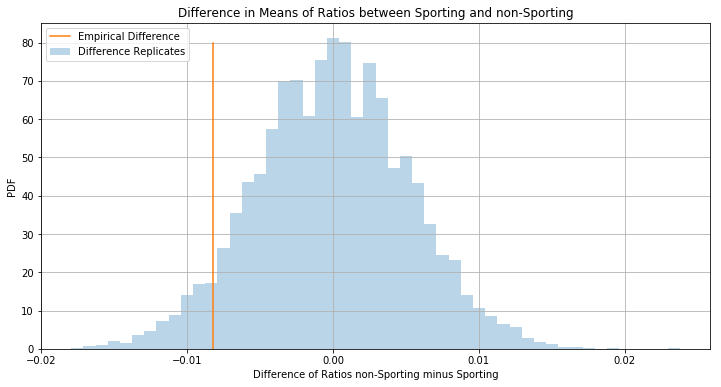

Sporting group data points: 6206. Non-Sporting group data points: 30177.
Sporting std:50.048262395664985
Non-Sporting std:45.12817311154221
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is -4.920089284122774.

The 95% confidence interval is -8.606169920017757 to 8.066121937611648.
p-val = 0.1237


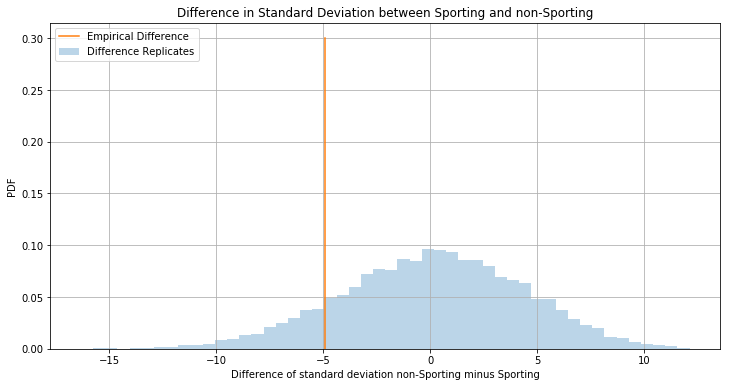

Hound group data points: 3655. Non-Hound group data points: 45338.
The empirical Hound ratio:0.7455540355677155
The empirical non-Hound ratio:0.7423794609378447
The empirical difference of ratios(non minus cat) is -0.0031745746298708077.

The 95% confidence interval is -0.014705094834427723 to 0.015155995951732448.
p-val = 0.3374


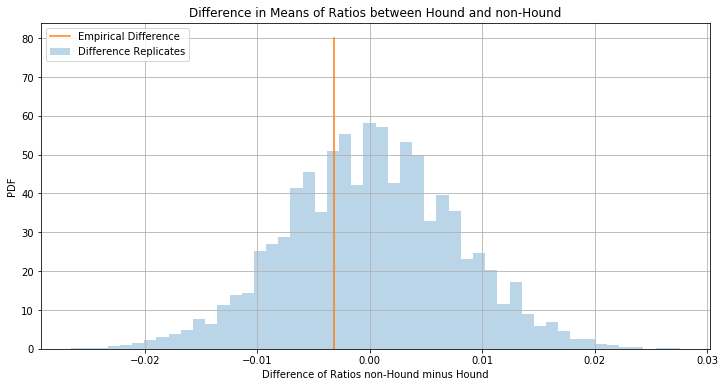

Hound group data points: 2725. Non-Hound group data points: 33658.
Hound std:31.08358426035393
Non-Hound std:46.98892547203684
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 15.90534121168291.

The 95% confidence interval is -12.31728303751737 to 10.873125070673053.
p-val = 0.0001


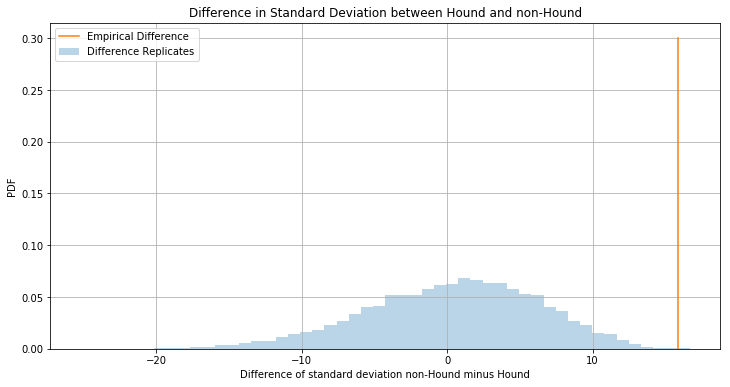

Herding group data points: 7116. Non-Herding group data points: 41877.
The empirical Herding ratio:0.7778246205733558
The empirical non-Herding ratio:0.7366334742221267
The empirical difference of ratios(non minus cat) is -0.04119114635122911.

The 95% confidence interval is -0.0109401031954941 to 0.011090547798356387.
p-val = 0.0


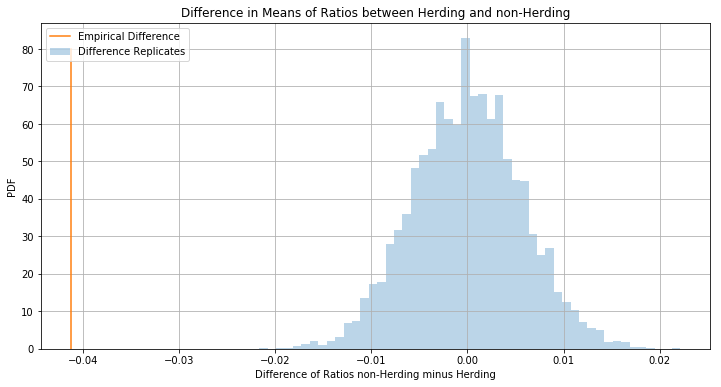

Herding group data points: 5535. Non-Herding group data points: 30848.
Herding std:35.78491125710622
Non-Herding std:47.60063182630704
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 11.81572056920082.

The 95% confidence interval is -8.811626050891967 to 8.286755556042136.
p-val = 0.0012


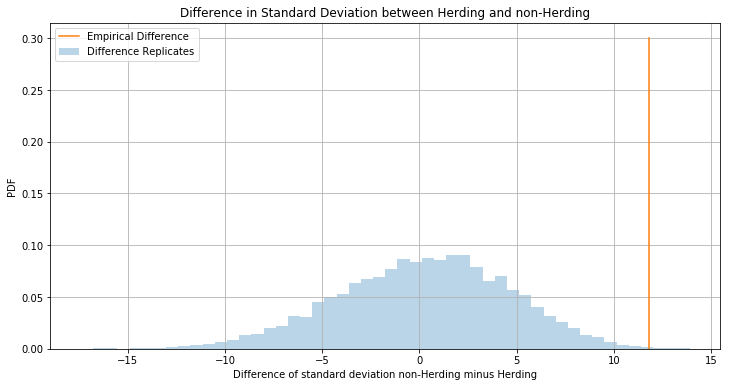

Terrier group data points: 11655. Non-Terrier group data points: 37338.
The empirical Terrier ratio:0.7371085371085371
The empirical non-Terrier ratio:0.7443355294873855
The empirical difference of ratios(non minus cat) is 0.007226992378848385.

The 95% confidence interval is -0.00909746320320004 to 0.009028311615488227.
p-val = 0.0614


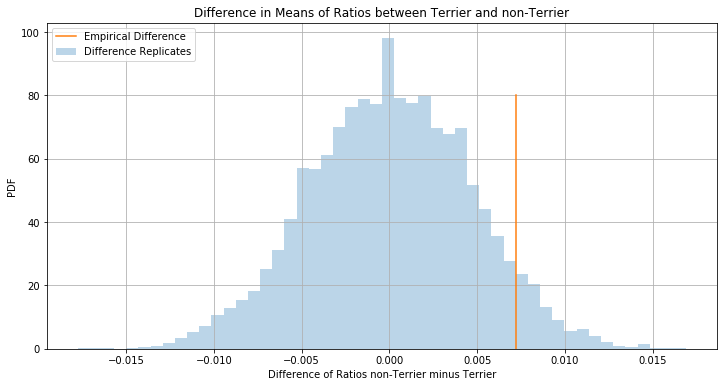

Terrier group data points: 8591. Non-Terrier group data points: 27792.
Terrier std:56.18671803955892
Non-Terrier std:42.18009192214006
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is -14.006626117418861.

The 95% confidence interval is -7.4048319250896535 to 7.2610996495250335.
p-val = 0.0001


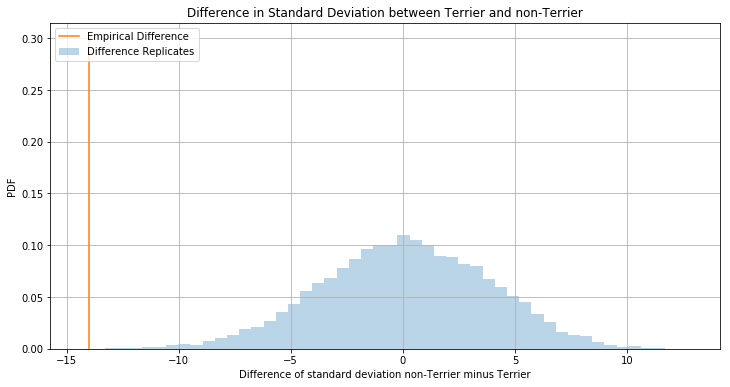

Non-Sporting group data points: 2688. Non-Non-Sporting group data points: 46305.
The empirical Non-Sporting ratio:0.7295386904761905
The empirical non-Non-Sporting ratio:0.7433754454162618
The empirical difference of ratios(non minus cat) is 0.013836754940071305.

The 95% confidence interval is -0.017259205269409272 to 0.016985712935968067.
p-val = 0.0601


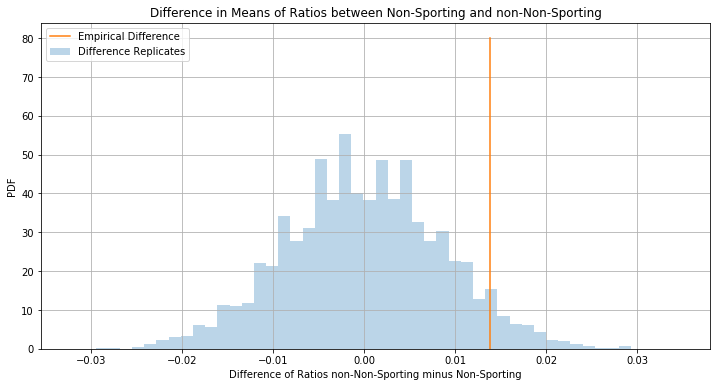

Non-Sporting group data points: 1961. Non-Non-Sporting group data points: 34422.
Non-Sporting std:40.87439856983871
Non-Non-Sporting std:46.27826728793967
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 5.403868718100959.

The 95% confidence interval is -14.293478344588994 to 11.942043595697896.
p-val = 0.258


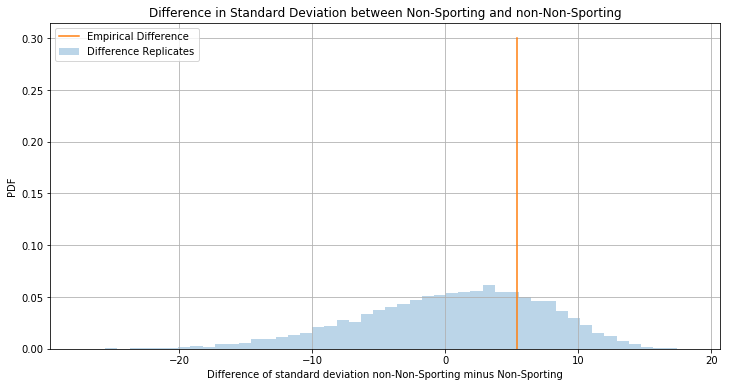

Toy group data points: 9352. Non-Toy group data points: 39641.
The empirical Toy ratio:0.7062660393498716
The empirical non-Toy ratio:0.7511919477308847
The empirical difference of ratios(non minus cat) is 0.04492590838101307.

The 95% confidence interval is -0.010050740576313166 to 0.010036881158094424.
p-val = 0.0


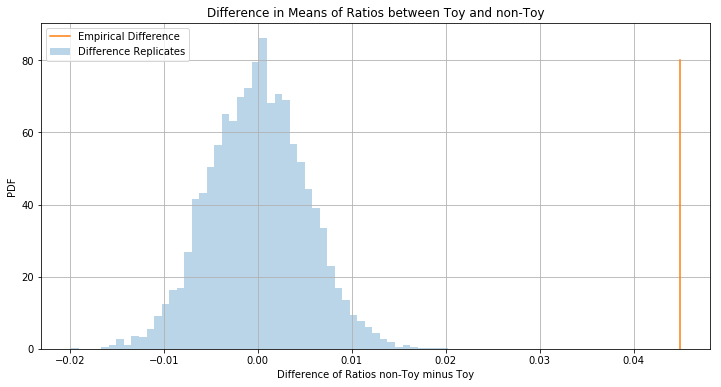

Toy group data points: 6605. Non-Toy group data points: 29778.
Toy std:30.754927072017427
Non-Toy std:48.65698349091249
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 17.90205641889506.

The 95% confidence interval is -8.392589273420567 to 7.807793132112799.
p-val = 0.0


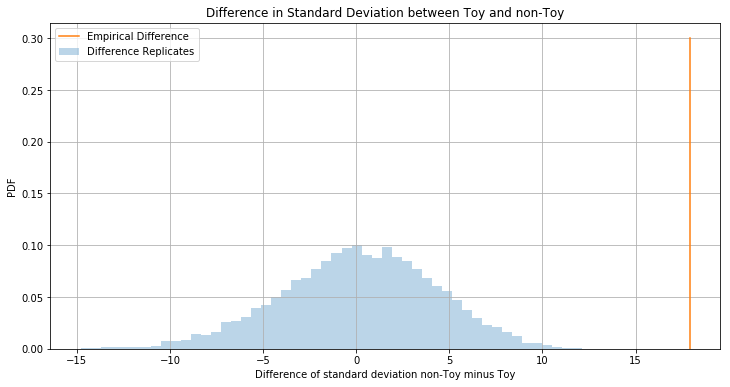

Working group data points: 4866. Non-Working group data points: 44127.
The empirical Working ratio:0.7642827784628031
The empirical non-Working ratio:0.7402270718607655
The empirical difference of ratios(non minus cat) is -0.024055706602037596.

The 95% confidence interval is -0.01288110699816466 to 0.012907746911538953.
p-val = 0.0004


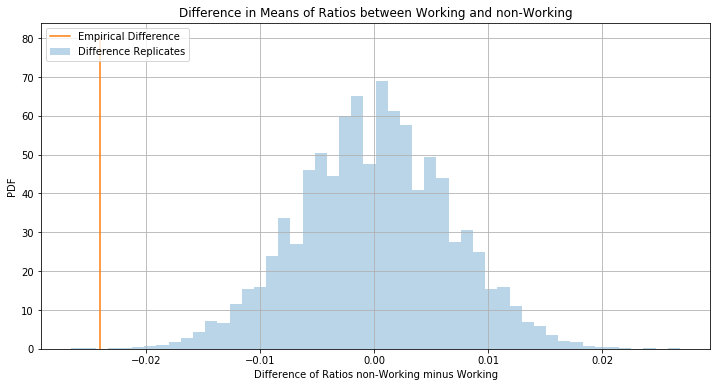

Working group data points: 3719. Non-Working group data points: 32664.
Working std:52.43803201550041
Non-Working std:45.218632804987436
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is -7.219399210512975.

The 95% confidence interval is -10.685391072795463 to 9.629310573887443.
p-val = 0.0823


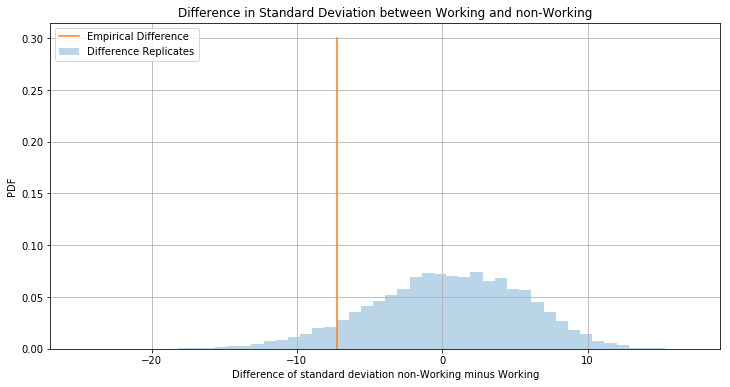

Misc group data points: 1380. Non-Misc group data points: 47613.
The empirical Misc ratio:0.7543478260869565
The empirical non-Misc ratio:0.742276269086174
The empirical difference of ratios(non minus cat) is -0.012071557000782551.

The 95% confidence interval is -0.023256162228255217 to 0.022973539378631447.
p-val = 0.1611


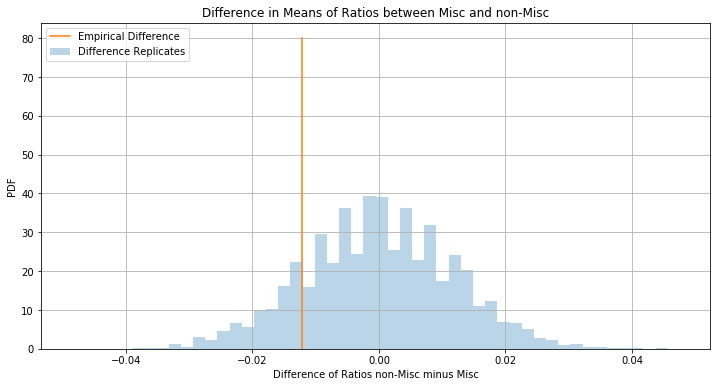

Misc group data points: 1041. Non-Misc group data points: 35342.
Misc std:63.255158327079364
Non-Misc std:45.390307065069855
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is -17.86485126200951.

The 95% confidence interval is -19.607518312534904 to 15.030853665271811.
p-val = 0.0363


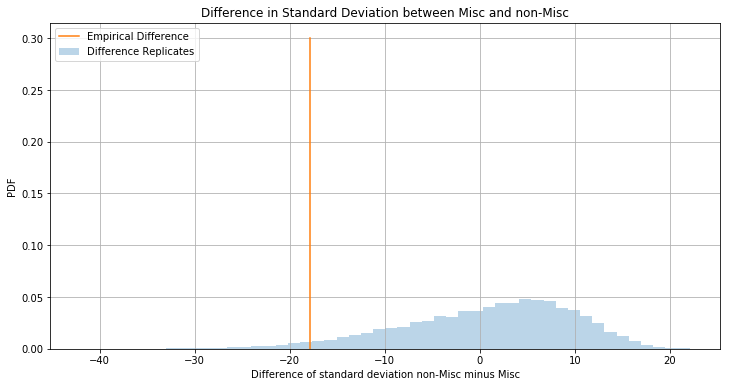

In [18]:
#Now check to see if any one group stands out from the rest statistically
for group in dogs_join.AKC_group.unique():
    adopt_diff_test('AKC_group', group, 10000)
    time_diff_test('AKC_group', group, 10000)

### Results (AKC breeds one  vs. all)
* Test Summary results:

|Group|Adoption Ratio|Time to Adoption|
|-----|--------------|----------------|
|Sporting|Not Significant|Not Significant|
|Hound|Not Significant|Significant(less)|
|Herding|Significant(more)|Significant(less)|
|Terrier|Not Significant|Significant(more)|
|Non-Sporting|Not Significant|Not Significant|
|Toy|Significant(less)|Significant(less)|
|Working|Significant(more)|Not Significant|
|Misc|Not Significant|Significant(more)|

* The results are a mixed bag of significant results.  No one AKC group stands out among the rest.  However, some groups pop up as being potentially troublesome, the ones such as Toy with a significant Adoption Ratio value suggesting their adoption ratio is lower compared to the others.  


* Also, Misc group seems to take longer to adopt than the other groups.
    
*****

## 6. Is there a correlation between time to adoption and intake age?
* I hypothesize that there is a correlation between time to adoption and intake age.
* To test this, all the dogs who have outcome_type of adoption will be organized by intake age and correlated with time to adoption.
* Test significance level is  $\alpha$  = 0.05.
* Null hypothesis is that there isn't a correlation.


* Test setup:
    * To simulate the null hypothesis, we need to:
        * Calculate the empirical correlation coefficient.
        * Permute one of the variables and keep one steady.
        * Then, then calculate the correlation coefficient(test statistic).
        * Repeat this many times until a distribution of correlation of coefficients are generated.
        * The p-value will be the count of instances where the permuted correlation coefficient is at least as extreme as the empirical correlation coefficient.

In [21]:
#define the correlation test function
def corr_test(data1, data2, label1, label2, size=1):
    """Runs a permutation test for correlation and generates a p-value, 95% confidence interval, and a histogram."""
    
    #print labels for the particular correlation test
    print("Test for correlation between {} and {}.".format(label1, label2))
    
    #calculate the empirical correlation
    emp_corr = np.corrcoef(data1, data2)[0][1]
    

    print("The empirical correlation coefficient is {}.".format(round(emp_corr,3)))
    print("")

    # Initialize permutation replicates: perm_replicates
    perm_replicates = np.empty(size)

    # Draw replicates
    for i in range(size):
        # Permute data1 measurments
        data1_permuted = np.random.permutation(data1)

        # Compute Pearson correlation
        perm_replicates[i] = np.corrcoef(data1_permuted,data2)[0][1]

    # Compute p-value: p
    if emp_corr < 0:
        p = np.sum(perm_replicates <= emp_corr)/len(perm_replicates)
    else:
        p = np.sum(perm_replicates >= emp_corr)/len(perm_replicates)
        
    print("The 95% confidence interval is {} to {}."
          .format(np.percentile(perm_replicates,2.5),np.percentile(perm_replicates,97.5)))
    print('p-val =', p)

    #make a histogram of the replicate correlations and show where the empirical result lies
    plt.figure(figsize=(12,6))
    pd.Series(perm_replicates).hist(alpha=0.3, normed=True, bins=50)
    plt.plot([emp_corr,emp_corr], [0,80])
    plt.xlabel('Pearson Correlation Coefficient')
    plt.ylabel('PDF')
    plt.legend(['Empirical Correlation','Correlation Replicates'], loc='upper left')
    plt.show()

Test for correlation between Intake Age and Time to Adoption.
The empirical correlation coefficient is 0.03.

The 95% confidence interval is -0.009752019895972953 to 0.010408926442807399.
p-val = 0.0


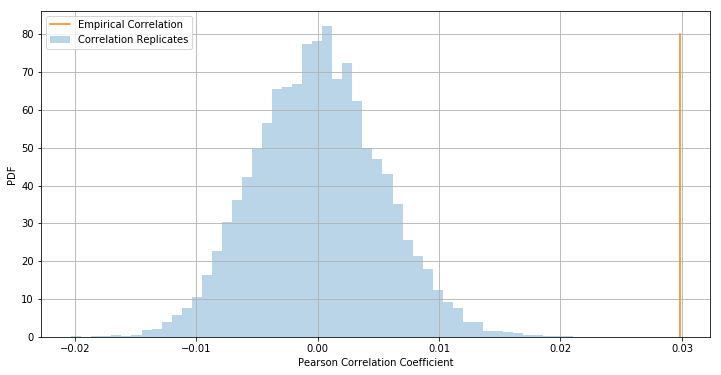

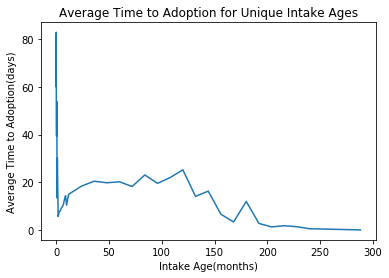

In [41]:
#run the correlation test
corr_test(dogs_adoptions.intake_age.values,dogs_adoptions.shelter_time.values,'Intake Age','Time to Adoption',10000)

#average shelter time for each unique age in intake age
avg_shelter_time = [np.mean(dogs_adoptions.shelter_time[dogs_adoptions.intake_age == age]) 
                    for age in dogs_adoptions.intake_age.sort_values().unique()]

#plot shelter time vs intake age
plt.plot(dogs_adoptions.intake_age.sort_values().unique(),avg_shelter_time)
plt.xlabel('Intake Age(months)')
plt.ylabel('Average Time to Adoption(days)')
plt.title('Average Time to Adoption for Unique Intake Ages')
plt.show()

### Results (Correlation between Intake Age and Time to Adoption)
* The test shows that in 10000 iterations, there were no instances found where the correlation coefficient was as extreme as the empirical correlation coefficient.
* So we can reject the null hypothesis that there is not a correlation between intake age and time to adoption.  The p-value is below $\alpha$. 
* Moreover, the empirical correlation suggests that there is a slight positive correlation between intake age and time to adoption.  However, this correlation is quite small at 0.03.
    * This suggests that the older the dog is upon intake, the longer it will take to get adopted.  This could be a trouble area to look out for in the shelter as well, focusing more time and attention promoting older dogs vs puppies as the puppy vs non puppy suggested as well.
    * However, looking at the scatterplot it seems more random at the left side of the graph, then it seems like the really old dogs have shorter times to adoptions but this is based on fewer samples.

*****

## 7. Are adoptions affected by seasons?
* I hypothesize that certain seasons have differences in distribution of adoptions and times to adoption.
* To test this, the groups will be the seasons are and will be tested one vs. all for each season.
* Test significance level is  $\alpha$  = 0.05.
* Null hypothesis is that there isn't a difference in distributions of adoptions or time to adoption.

Spring group data points: 13147. Non-Spring group data points: 35846.
The empirical Spring ratio:0.752947440480718
The empirical non-Spring ratio:0.7388272052669754
The empirical difference of ratios(non minus cat) is -0.014120235213742616.

The 95% confidence interval is -0.008714310243279733 to 0.008958906006310663.
p-val = 0.0009


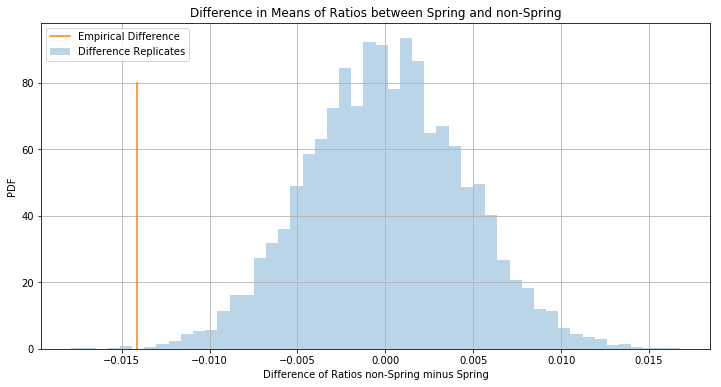

Spring group data points: 9899. Non-Spring group data points: 26484.
Spring std:40.61953022331616
Non-Spring std:47.86655824445314
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 7.247028021136977.

The 95% confidence interval is -7.158628390600147 to 6.845283002018545.
p-val = 0.0194


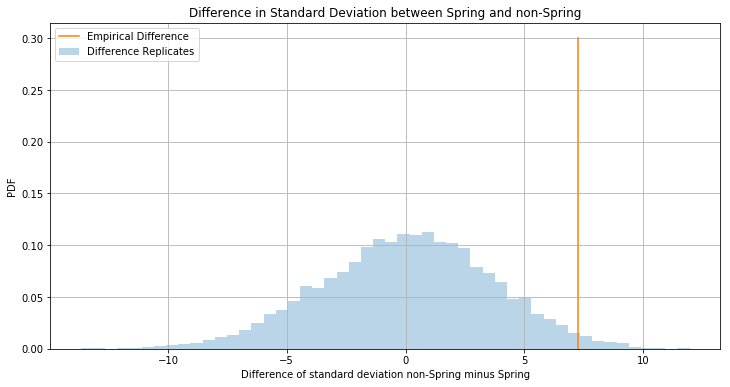

Winter group data points: 12344. Non-Winter group data points: 36649.
The empirical Winter ratio:0.7664452365521711
The empirical non-Winter ratio:0.7345903026003437
The empirical difference of ratios(non minus cat) is -0.03185493395182737.

The 95% confidence interval is -0.00900428982394097 to 0.00886469729028283.
p-val = 0.0


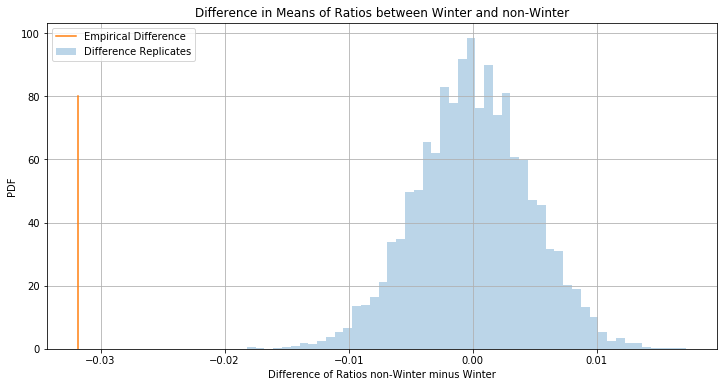

Winter group data points: 9461. Non-Winter group data points: 26922.
Winter std:46.129179676464645
Non-Winter std:45.96573687877136
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is -0.1634427976932855.

The 95% confidence interval is -7.19359533973376 to 6.899602111704855.
p-val = 0.4723


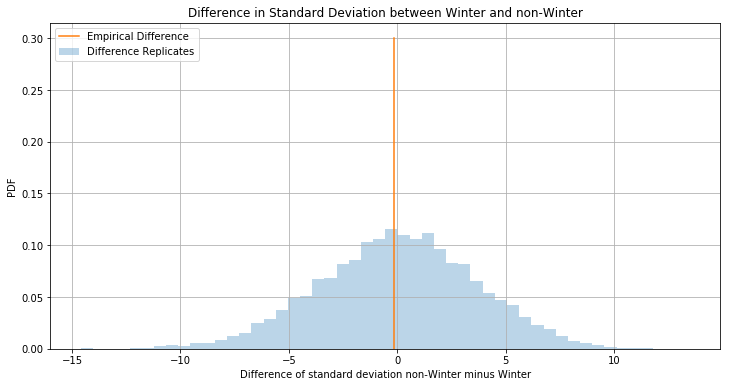

Fall group data points: 11752. Non-Fall group data points: 37241.
The empirical Fall ratio:0.7242171545268891
The empirical non-Fall ratio:0.7484224376359389
The empirical difference of ratios(non minus cat) is 0.02420528310904979.

The 95% confidence interval is -0.008818204147039266 to 0.009204783813063666.
p-val = 0.0


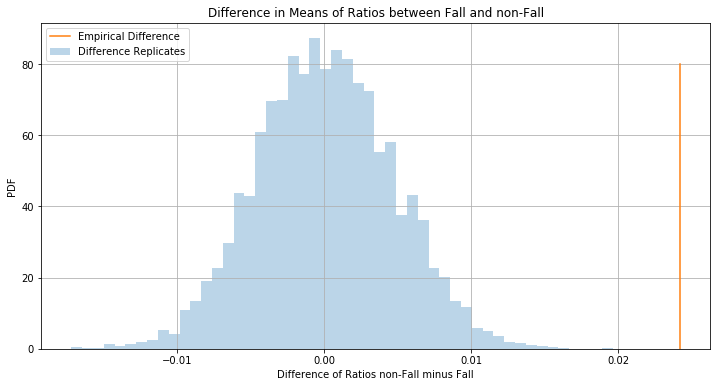

Fall group data points: 8511. Non-Fall group data points: 27872.
Fall std:53.37403140882145
Non-Fall std:43.503174220364976
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is -9.870857188456476.

The 95% confidence interval is -7.450914746375159 to 7.169227368717598.
p-val = 0.0039


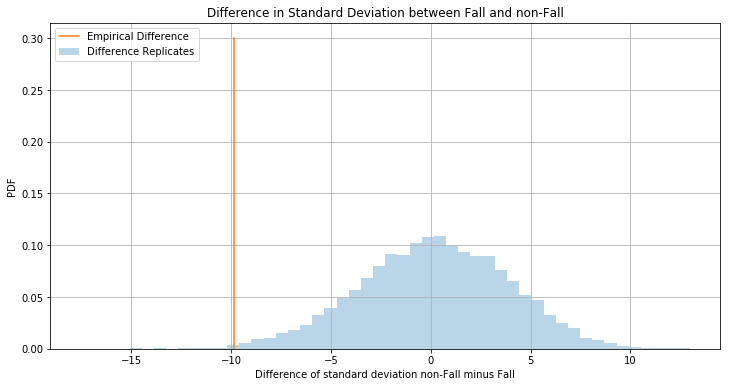

Summer group data points: 11750. Non-Summer group data points: 37243.
The empirical Summer ratio:0.7244255319148937
The empirical non-Summer ratio:0.7483553956448191
The empirical difference of ratios(non minus cat) is 0.02392986372992545.

The 95% confidence interval is -0.008985513770687126 to 0.009154329901206633.
p-val = 0.0


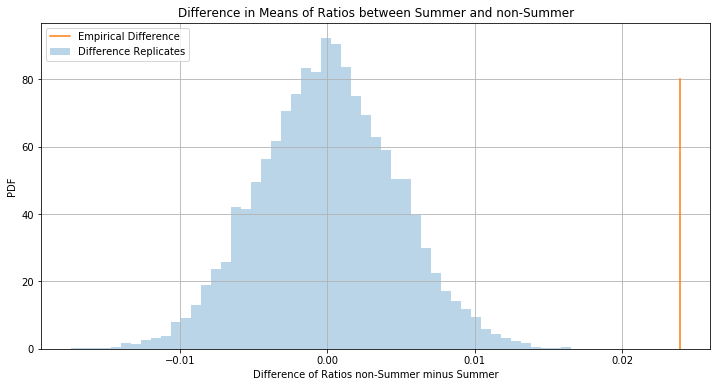

Summer group data points: 8512. Non-Summer group data points: 27871.
Summer std:43.73753906434269
Non-Summer std:46.67876658164648
The empirical difference of time to adoption expected value or standard deviation(non minus cat) is 2.941227517303787.

The 95% confidence interval is -7.463549195755845 to 7.1291936279603.
p-val = 0.2288


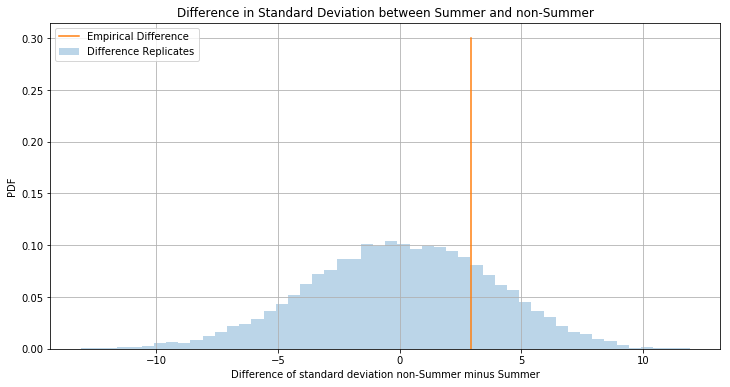

In [31]:
#Now check to see if any one group stands out from the rest statistically
for group in dogs_join.intake_season.unique():
    adopt_diff_test('intake_season', group, 10000)
    time_diff_test('intake_season', group, 10000)

### Results (Seasons one  vs. all)
* Test Summary results:

|Season|Adoption Ratio|Time to Adoption|
|-----|--------------|----------------|
|Spring|Significant(More)|Significant(less)|
|Winter|Significant(More)|Not Significant|
|Fall|Significant(less)|Significant(more)|
|Summer|Significant(less)|Not Significant|

* The results are all significant results for the adoptability tests.  This means that we can reject the null hypothesis that the distribution of adoption ratios is not different.  The test results suggest that Summer and Fall may be times with less adoptability and that Spring and Winter have higher adoptability.


* For time to adoption, the results are mixed significance.  However, spring seems to have lower times to adoption(expected value) as compared to the other seasons.  Moreover, Fall seems to have higher times to adoption(expected value) as compared to the other seasons.

*****

## That will conclude the statistical testing.  Now onto machine learning and prediction.